In [39]:
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw
import time
import re
import math
from matplotlib import pyplot as plt
import tensorflow as tf
import wandb
from wandb.keras import WandbCallback

path = "/home/andrew/ros_ws/src/2020T1_competition/controller/prev"
labels = ['00', '01', '02', '10', '11', '12'] # one label representing each combination of foward and turning

In [40]:
img_sets = []
from random import randint

# load and augment dataset
for filename in os.listdir(path):
    if filename.endswith(".jpg"): 
        label = filename.split('_')[0]
        img = np.array(Image.open(path+"/"+filename))
        img_sets.append(np.array([[img, labels.index(label)]]))

        # todo: make this less ugly
        # h, w = img.shape
        # img = img.reshape(h, w, 1)
        # img_aug = tf.keras.preprocessing.image.apply_affine_transform(img, theta=randint(-2,2), tx=0,
        #                                                         ty=0, shear=randint(-10,10), row_axis=0, col_axis=1,
        #                                                         fill_mode='nearest', cval=0.0, order=1)
        # img_aug = img.reshape(h, w)
        # img_sets.append(np.array([[img_aug, labels.index(label)]]))
                                                                


11327
3
(90, 160)


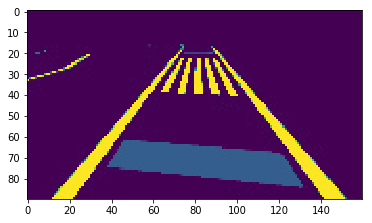

In [41]:
# making sure things are cool and good
n = 100
plt.imshow(img_sets[n][0][0])
plt.show
print(len(img_sets))
print(img_sets[n][0][1])
print(img_sets[n][0][0].shape)

In [42]:
all_dataset = np.concatenate(img_sets, axis=0)
np.random.shuffle(all_dataset)

In [43]:
X_dataset_orig = np.array([data[0] for data in all_dataset[:]])
Y_dataset_orig = np.array([[data[1]] for data in all_dataset]).T

NUMBER_OF_LABELS = 6
CONFIDENCE_THRESHOLD = 0.01

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y
  
# Normalize X (images) dataset
X_dataset = X_dataset_orig/255.

# Convert Y dataset to one-hot encoding
Y_dataset = convert_to_one_hot(Y_dataset_orig, NUMBER_OF_LABELS).T

In [44]:
n, h, w = X_dataset.shape
X_dataset = X_dataset.reshape(n, h, w, 1)
print(X_dataset.shape)

(11327, 90, 160, 1)


In [45]:
VALIDATION_SPLIT = 0.2

print("Total examples: {}\nTraining examples: {}\nTest examples: {}".
      format(X_dataset.shape[0],
             math.ceil(X_dataset.shape[0] * (1-VALIDATION_SPLIT)),
             math.floor(X_dataset.shape[0] * VALIDATION_SPLIT)))
print("X shape: " + str(X_dataset.shape))
print("Y shape: " + str(Y_dataset.shape))

Total examples: 11327
Training examples: 9062.0
Test examples: 2265.0
X shape: (11327, 90, 160, 1)
Y shape: (11327, 6)


In [46]:
# model setup 
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

In [47]:
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [48]:
# input_shape needs to match the input, duh
conv_model = models.Sequential()
# this creates our convolution kernel, (3,3) is the size of it
conv_model.add(layers.Conv2D(12, (3, 3), activation='relu',
                             input_shape=(h, w, 1)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(36, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(36, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(12*36, activation='relu'))
conv_model.add(layers.Dense(6, activation='softmax'))

In [49]:
conv_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 88, 158, 12)       120       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 44, 79, 12)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 42, 77, 36)        3924      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 21, 38, 36)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 19, 36, 36)        11700     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 9, 18, 36)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5832)             

In [59]:
reset_weights(conv_model)

In [61]:
wandb.init(project='enph353', entity='nullcline')
config = wandb.config

acc,0.96744
loss,0.07953
_timestamp,1617516924
_step,39
epoch,19
val_acc,0.94131
best_val_loss,0.15776
_runtime,1186
best_epoch,12
val_loss,0.21651


Problem at: <ipython-input-61-2ccc015b2f82> 1 <module>
Traceback (most recent call last):
  File "/home/andrew/.local/lib/python2.7/site-packages/wandb/sdk_py27/wandb_init.py", line 745, in init
    run = wi.init()
  File "/home/andrew/.local/lib/python2.7/site-packages/wandb/sdk_py27/wandb_init.py", line 406, in init
    self._wl._global_run_stack[-1].finish()
  File "/home/andrew/.local/lib/python2.7/site-packages/wandb/sdk_py27/wandb_run.py", line 1170, in finish
    self._atexit_cleanup(exit_code=exit_code)
  File "/home/andrew/.local/lib/python2.7/site-packages/wandb/sdk_py27/wandb_run.py", line 1504, in _atexit_cleanup
    self._on_final()
  File "/home/andrew/.local/lib/python2.7/site-packages/wandb/sdk_py27/wandb_run.py", line 1706, in _on_final
    self._show_history()
  File "/home/andrew/.local/lib/python2.7/site-packages/wandb/sdk_py27/wandb_run.py", line 1804, in _show_history
    history_table += "<tr><td>{}</td><td>{}</td></tr>".format(*row)
UnicodeEncodeError: 'ascii' c

Exception: problem

In [58]:
lr= 1e-4
config = wandb.config
config.learning_rate = lr

conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.Adam(lr=lr),
                   metrics=['acc'])

In [60]:
history_conv = conv_model.fit(X_dataset, Y_dataset, 
                              validation_split=VALIDATION_SPLIT, 
                              epochs=20, 
                              batch_size=420,
                              callbacks=[WandbCallback()])

Train on 9061 samples, validate on 2266 samples
Epoch 1/20
9061/9061 [==============================] - 26s 3ms/sample - loss: 0.2435 - acc: 0.9195 - val_loss: 0.1832 - val_acc: 0.9404
Epoch 2/20
9061/9061 [==============================] - 27s 3ms/sample - loss: 0.1618 - acc: 0.9485 - val_loss: 0.1759 - val_acc: 0.9391
Epoch 3/20
9061/9061 [==============================] - 27s 3ms/sample - loss: 0.1523 - acc: 0.9492 - val_loss: 0.1728 - val_acc: 0.9400
Epoch 4/20
9061/9061 [==============================] - 26s 3ms/sample - loss: 0.1458 - acc: 0.9503 - val_loss: 0.1630 - val_acc: 0.9440
Epoch 5/20
9061/9061 [==============================] - 22s 2ms/sample - loss: 0.1374 - acc: 0.9518 - val_loss: 0.1586 - val_acc: 0.9466
Epoch 6/20
9061/9061 [==============================] - 21s 2ms/sample - loss: 0.1361 - acc: 0.9523 - val_loss: 0.1627 - val_acc: 0.9457
Epoch 7/20
9061/9061 [==============================] - 22s 2ms/sample - loss: 0.1355 - acc: 0.9516 - val_loss: 0.1741 - val_acc: 

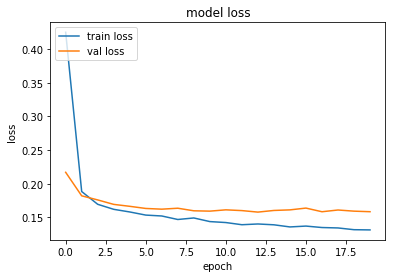

In [57]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

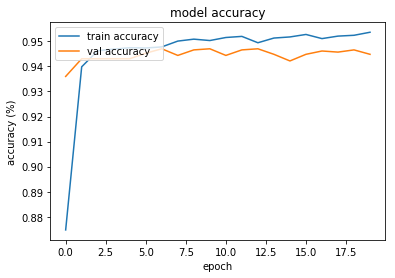

In [55]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

In [56]:
conv_model.save('./models/OLv4.h5')